<a href="https://colab.research.google.com/github/andrea-floh/ing-machine-learning-challenge/blob/master/MLC_Ex_3_1_Toys_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ex 3.1 Classification

**Week 3 - Supervised Learning**

* Explore the toy datasets that come with scikit-learn
* Pick one for classification
* Explore different scikit-learn classification algorithms
* For extra credits post the notebooks on GitHub and share the link in Week 3's MatterMost channel

So... Let's start and try to reuse things from the lessons.


## Setup and Preparation

This is stuff I assume to need with regards to imports. Maybe I forgot libraries, we will see.

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn.datasets as data
from sklearn.neighbors import KNeighborsClassifier

## Toy dataset

Let's see the Iris dataset as I like *eyes*. 
* Load data.
* Explore types and content.

In [0]:
iris = data.load_iris()
#help(iris) # bunch object

irisTuple = data.load_iris(True)
#help(irisTuple) # tuple object

#print(iris.keys())
#print(iris['DESCR'])

print('data is of type', type(iris.data))
print('target is of type', type(iris.target))

data is of type <class 'numpy.ndarray'>
target is of type <class 'numpy.ndarray'>


Let's use pandas dataframes as we have used it in the lessons and exercises.

In [0]:
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)

print(iris_df.head())
print(iris_df.shape)
iris_df.describe()
iris_df.info()
print('amount of null values', iris_df.isnull().sum())

species_df = pd.DataFrame(iris.target).apply(lambda x: iris['target_names'][x])
print(species_df.head())
print(species_df.shape)
species_df.describe()


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
(150, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
sepal length (cm)    150 non-null float64
sepal width (cm)     150 non-null float64
petal length (cm)    150 non-null float64
petal width (cm)     150 non-null float64
dtypes: float64(4)
memory usage: 4.8 KB
amount of null values sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64
        0
0  setosa
1  setosa
2  setosa
3  setosa
4  setosa
(150, 1)


,0
count,150
unique,3
top,versicolor
freq,50


Right. *Flowers*. No *eyes*...
https://en.wikipedia.org/wiki/Iris_flower_data_set

But the data looks clean and in good shape.

Basically I would like to see the existing data first. How are the values of the 4 categories distributed?
How does the distribution relate to the classification/target attribute?

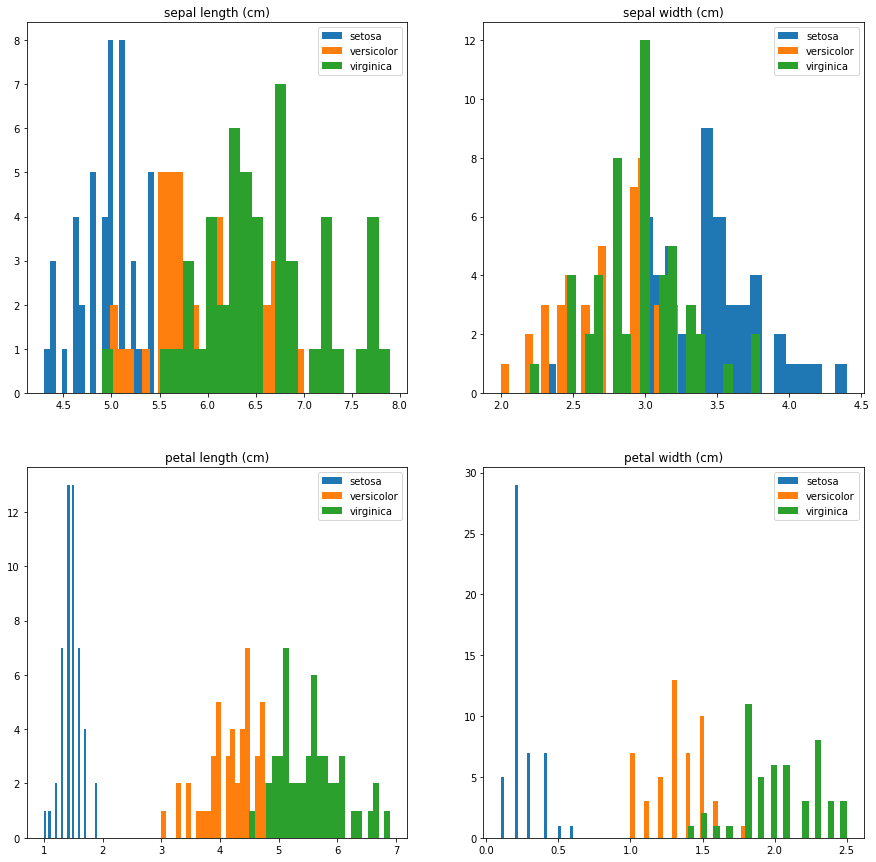

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs_flat = axs.ravel()  # is there any other easier / prettier way to do the subplots dynamically?
for feature_index, feature in enumerate(iris.feature_names):
  for species in np.unique(species_df):
    ax = axs_flat[feature_index]
    ax.set_title(feature)
    ax.hist(iris_df[feature].iloc[np.where(species_df == species)[0]], bins=25, label=species)
  ax.legend()


Okay, so petal with and length seem to somehow identify the sepcies setosa. But besides that, the species are overlapping per feature and we will have to take multiple features into consideration for performing a good classification.

I would like to see the scatter plots for the different feature combinations in a similar way...

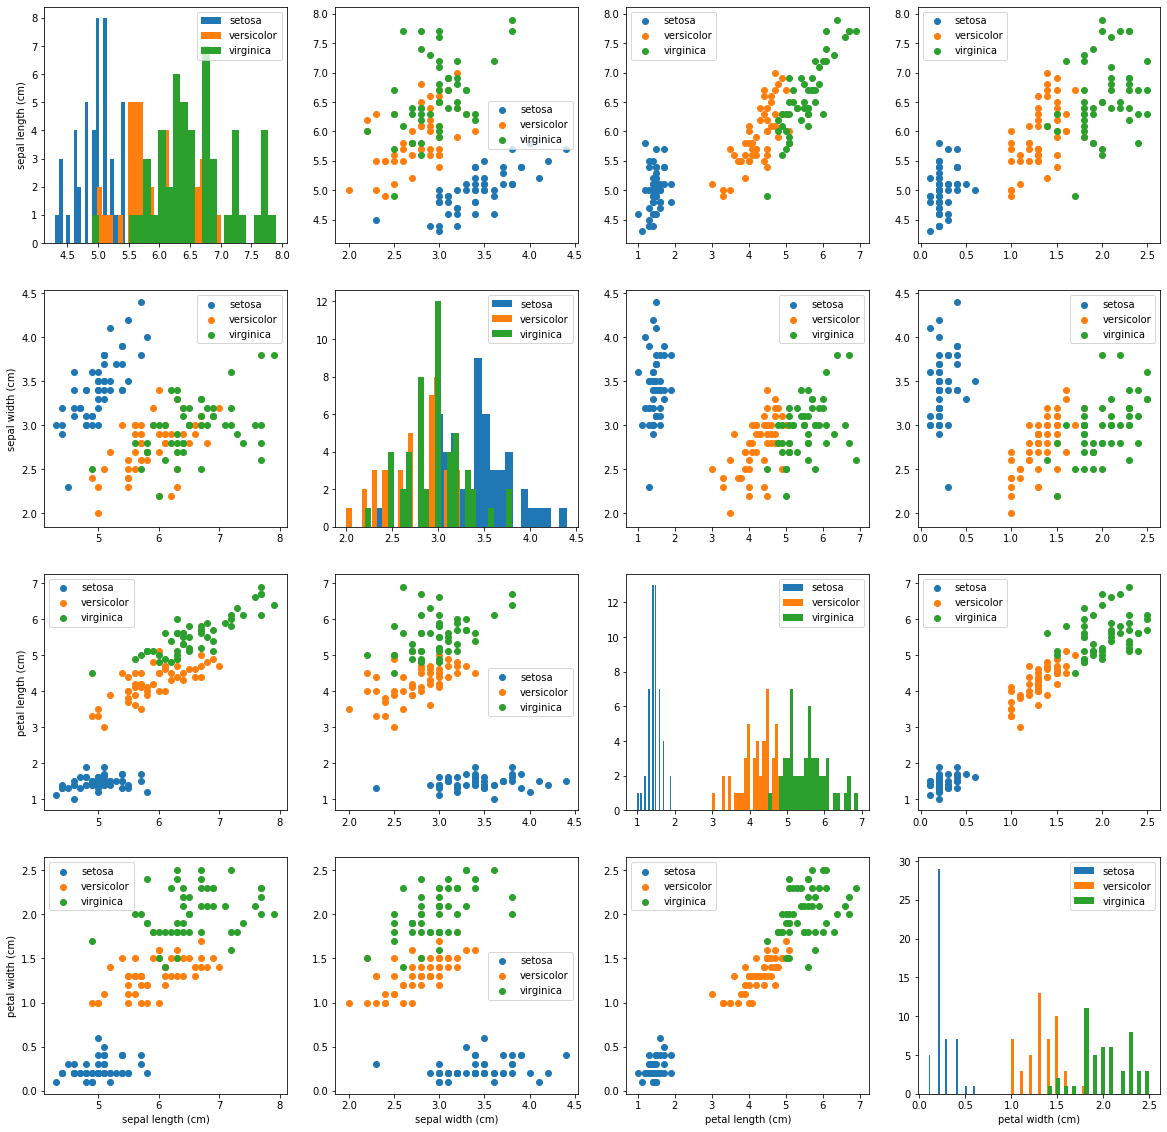

In [0]:
fig, axs = plt.subplots(4, 4, figsize=(20,20))

for featureRow_index, featureRow in enumerate(iris.feature_names):
  axs[featureRow_index, 0].set_ylabel(featureRow)
  for featureCol_index, featureCol in enumerate(iris.feature_names):
    if featureRow_index == 0:
      axs[3, featureCol_index].set_xlabel(featureCol)
    ax = axs[featureRow_index, featureCol_index]
    if featureCol == featureRow:
      # hist
      for species in np.unique(species_df):
        ax.hist(iris_df[featureCol].iloc[np.where(species_df == species)[0]], bins=25, label=species)
        ax.legend()
    else:
      # plot scatter plot
      for species in np.unique(species_df):
        ax.scatter(iris_df[featureCol].iloc[np.where(species_df == species)[0]], iris_df[featureRow].iloc[np.where(species_df == species)[0]], label=species)
        ax.legend()

plt.show()

Well, well, well, ... That looks good. Even though having the legend 16 times is not very useful. At least the axis labels are not repeated all over gain. If someone new the available libraries and features, one could have saved a lot of time.

### Seaborn plot

Interesting plot provided by seaborn. (first additional import)

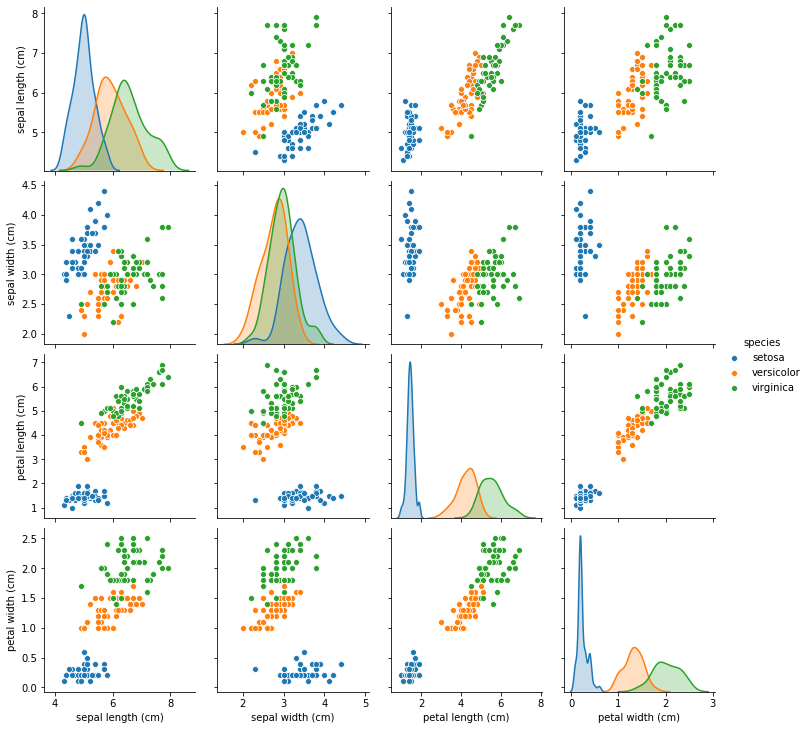

In [0]:
import seaborn as sns

seaborn_df = iris_df
seaborn_df['species'] = species_df

sns.pairplot(seaborn_df, hue='species')

Yep. Neat and clean. And so few lines of code...

Enough of visual exploration and plotting. Let's get to the classification.

## Classification algorithms

Let's see if we can create models that can classify our flowers.

As we do not just do this for fun, we will also have two flowers, which we will classify.

### Additional Iris data

Let's assume we have one unknown Iris with the following feature:


```
# (sepal length, sepal width, petal length, petal width)
unknownIris1 = (5.0, 4.0, 1.0, 0.4)
unknownIris2 =  (5.5, 3.0, 6.0, 0.2)
```
I would assume that the first one is a setosa, but I have now idea, what the other one is.


In [0]:
unknownIris1 = [[5.0, 4.0, 1.0, 0.4]]
unknownIris2 =  [[5.5, 3.0, 6.0, 0.2]]

### KNeighbors

By using the KNeighborsClassifier we evaluate which amount of neighbours brings the best score for a model.



In [0]:
from sklearn.model_selection import train_test_split

iris_train, iris_test, species_train, species_test = train_test_split(iris.data, iris.target, test_size = 0.25, random_state=42, stratify=iris.target)

def scoreKNeighborsWith(n=3):
  # k-NN classifier with n neighbors
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(iris_train, species_train)
  return knn.score(iris_test, species_test)

result = {}
for countNeighbors in range(1, 9):
  result.update({countNeighbors: scoreKNeighborsWith(countNeighbors)})

maxValue = max(result.values())

print(result)
print('best score is achieved with the following amounts of neighbors:', [n for n, v in result.items() if v == maxValue])


{1: 0.9473684210526315, 2: 0.9210526315789473, 3: 0.9736842105263158, 4: 0.9736842105263158, 5: 0.9736842105263158, 6: 0.9473684210526315, 7: 0.9473684210526315, 8: 0.9473684210526315}
best score is achieved with the following amounts of neighbors: [3, 4, 5]


One has to be aware, that the result is heavily depending on the test size of the trainings set.  Smaller or higher percentage also changes the score of the model. For the recommended 25% test data (and as well 20%), the results are the same.

As shown in the lesson, we can also plot the accuracy for the different amount of neighbors.

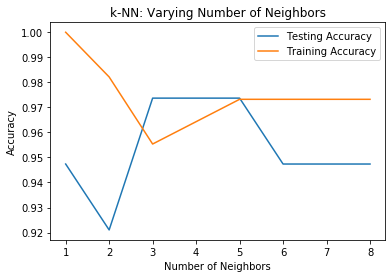

In [0]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(iris_train, species_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(iris_train, species_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(iris_test, species_test)

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

What about our unknown irises?

In [44]:
ui1_kn = knn.predict(unknownIris1);
ui2_kn = knn.predict(unknownIris2);
print('unknown iris 1 is predicted as', iris.target_names[ui1_kn])
print('unknown iris 2 is predicted as', iris.target_names[ui2_kn])

unknown iris 1 is predicted as ['setosa']
unknown iris 2 is predicted as ['virginica']


The assumption about the unknown iris 1 was correct. The second one seem sto be a virginica. Let's see if other models state the same.

### Decision Tree

Did I read about decision trees?

Accuracy: 0.8947368421052632


[Text(133.92000000000002, 199.32, 'X[3] <= 0.8\ngini = 0.667\nsamples = 112\nvalue = [38, 37, 37]'),
 Text(100.44000000000001, 163.07999999999998, 'gini = 0.0\nsamples = 38\nvalue = [38, 0, 0]'),
 Text(167.40000000000003, 163.07999999999998, 'X[3] <= 1.7\ngini = 0.5\nsamples = 74\nvalue = [0, 37, 37]'),
 Text(66.96000000000001, 126.83999999999999, 'X[2] <= 4.95\ngini = 0.142\nsamples = 39\nvalue = [0, 36, 3]'),
 Text(33.480000000000004, 90.6, 'gini = 0.0\nsamples = 35\nvalue = [0, 35, 0]'),
 Text(100.44000000000001, 90.6, 'X[0] <= 6.15\ngini = 0.375\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(66.96000000000001, 54.359999999999985, 'X[2] <= 5.05\ngini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(33.480000000000004, 18.119999999999976, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(100.44000000000001, 18.119999999999976, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(133.92000000000002, 54.359999999999985, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]'),
 Text(267.84000000000003

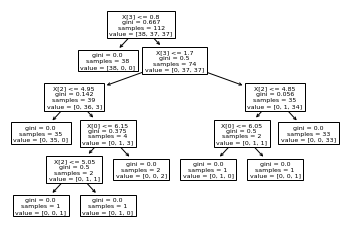

In [38]:
from sklearn import tree
from sklearn import metrics

clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris_train, species_train)

species_pred = clf.predict(iris_test)
print("Accuracy:",metrics.accuracy_score(species_test, species_pred))

tree.plot_tree(clf)

In [45]:
ui1_t = clf.predict(unknownIris1);
ui2_t = clf.predict(unknownIris2);
print('unknown iris 1 is predicted as', iris.target_names[ui1_t])
print('unknown iris 2 is predicted as', iris.target_names[ui2_t])

unknown iris 1 is predicted as ['setosa']
unknown iris 2 is predicted as ['setosa']


The tree classifies the unknown iris 2 as setosa. So for this untypical iris, the second model results in a different classification.

### Neural network models

This sound pretty cool too.

In [56]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

nnClf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(9,9,9), random_state=1)
nnClf.fit(iris_train, species_train)

nn_pred = nnClf.predict(iris_test)

print(confusion_matrix(species_test,nn_pred))
print(classification_report(species_test,nn_pred))

[[12  0  0]
 [ 0 13  0]
 [ 0  1 12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.96        13
           2       1.00      0.92      0.96        13

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



In [52]:
ui1_nn = nnClf.predict(unknownIris1);
ui2_nn = nnClf.predict(unknownIris2);
print('unknown iris 1 is predicted as', iris.target_names[ui1_nn])
print('unknown iris 2 is predicted as', iris.target_names[ui2_nn])

unknown iris 1 is predicted as ['setosa']
unknown iris 2 is predicted as ['versicolor']


Hum... again versicolor. But not from the very beginning. When the model was not as accurate (differnt hidden layer sizes and other attributes), the prediction was again setosa.

But as the accury of the network is quite good now (only one iut of 38 flowers incorrect), versicolor seems reasonable.

### Support Vector Machines

By now, I think I've spend too much time on classification, but let's do one more.

In [61]:
from sklearn import svm

svmClf = svm.SVC()
svmClf.fit(iris_train, species_train)

print('score train', svmClf.score(iris_train, species_train))
print('score test', svmClf.score(iris_test, species_test))

score train 0.9732142857142857
score test 0.9210526315789473


Well, we've had better values. Didn't we? But let's see what it tells us about our unknown flowers.

In [60]:
ui1_svm = svmClf.predict(unknownIris1);
ui2_svm = svmClf.predict(unknownIris2);
print('unknown iris 1 is predicted as', iris.target_names[ui1_svm])
print('unknown iris 2 is predicted as', iris.target_names[ui2_svm])

unknown iris 1 is predicted as ['setosa']
unknown iris 2 is predicted as ['versicolor']


Okay, okay. I believe the second flower is definitely of type versicolor.